In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# remember to clone the repo
# !git clone https://github.com/MatthewZhang473/LoRA_Qwen0.5B.git

In [2]:
import os

# Change the current directory to your repository in Google Drive
os.chdir('/content/drive/MyDrive/LoRA_Qwen0.5B')

# Now you can run scripts or access files within your repository
# For example, to list the files in the current directory:
!ls

colabs		   llmtime.pdf	qwen.pdf   src		 wandb
fine_tuned_models  main.pdf	Readme.md  test-trainer


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
from src.data.data_loader import LotkaVolterraDataset, encode, decode
from datetime import datetime

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Set pad_token to eos_token if it's not set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")


def preprocess_function(examples):
    processed_inputs = tokenizer(examples["text"],
                     truncation=True,
                     padding=True) # Add padding here
    processed_inputs["labels"] = processed_inputs["input_ids"].copy()
    return processed_inputs

# Load dataset
raw_dataset = LotkaVolterraDataset()
trajectories = raw_dataset.trajectories
texts = encode(trajectories)
dataset = Dataset.from_dict({"text": texts})

# Split dataset into training, validation, and test sets
split_dataset = dataset.train_test_split(test_size=0.2) # Split into train and temp (40% for temp)
temp_dataset = split_dataset['test']
train_dataset = split_dataset['train']
split_temp_dataset = temp_dataset.train_test_split(test_size=0.5) # Split temp into validation and test (50% of 40% = 20% for each)
eval_dataset = split_temp_dataset['train'] # This will be the validation set
test_dataset = split_temp_dataset['test']   # This will be the test set


tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text"])
tokenized_eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=["text"])
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["text"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [6]:
lora_config = LoraConfig(
    r=12,
    target_modules=["q_proj", "v_proj"],
    task_type=TaskType.CAUSAL_LM,
    lora_alpha=32,
    lora_dropout=0.05
)

In [7]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 811,008 || all params: 494,843,776 || trainable%: 0.1639


In [8]:
training_args = TrainingArguments(
    "test-trainer",
    fp16=True,
    num_train_epochs=100,
    learning_rate=5e-5,
    eval_strategy="steps",   # ← enables evaluation during training
    eval_steps=100,                # ← evaluate every 100 steps
    logging_strategy="steps",      # ← log every X steps
    logging_steps=100,             # ← match eval frequency for W&B updates
    report_to="none"
)


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset, # Use the training dataset
    eval_dataset=tokenized_eval_dataset, # Use the evaluation dataset
    data_collator=data_collator
)

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [9]:
trainer.train()


Step,Training Loss,Validation Loss
100,0.812000,0.754219
200,0.722800,0.708997
300,0.692300,0.690699
400,0.676200,0.675192
500,0.663100,0.666365
600,0.653900,0.656415
700,0.645900,0.649570
800,0.638200,0.642996
900,0.632400,0.635860
1000,0.626500,0.633903


TrainOutput(global_step=10000, training_loss=0.5547090763092041, metrics={'train_runtime': 3649.9358, 'train_samples_per_second': 21.918, 'train_steps_per_second': 2.74, 'total_flos': 2.071329942528e+17, 'train_loss': 0.5547090763092041, 'epoch': 100.0})

In [10]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
lora_settings = f"r{lora_config.r}_alpha{lora_config.lora_alpha}"
output_dir = f"./fine_tuned_models/{timestamp}_{lora_settings}"
os.makedirs(output_dir, exist_ok=True)
trainer.save_model(output_dir)
print(f"Model saved to {output_dir}")

Model saved to ./fine_tuned_models/20251017_140153_r12_alpha32


## Load & Inference

In [12]:
# Load the base model
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

# List available checkpoints
checkpoints_dir = "./fine_tuned_models/"
if os.path.exists(checkpoints_dir):
    available_checkpoints = [d for d in os.listdir(checkpoints_dir) if os.path.isdir(os.path.join(checkpoints_dir, d))]
    print("Available checkpoints:")
    for checkpoint in available_checkpoints:
        print(f"- {checkpoint}")
else:
    print(f"No checkpoints found in {checkpoints_dir}")

# Specify the directory where you saved the LoRA adapter weights you want to load
# Replace "YYYYMMDD_HHMMSS_rX_alphaY" with the actual timestamp and settings of the model you want to load
lora_model_path = "./fine_tuned_models/20251017_140153_r12_alpha32" # <--- Change this to the checkpoint you want to load

# Load the LoRA adapter weights on top of the base model
try:
    model = PeftModel.from_pretrained(base_model, lora_model_path)
    print(f"LoRA fine-tuned model loaded successfully from {lora_model_path}!")
except Exception as e:
    print(f"Error loading model from {lora_model_path}: {e}")
    model = None # Set model to None if loading fails

Available checkpoints:
- 20251017_101834_r6_alpha32
- 20251017_113135_r12_alpha32
- 20251017_140153_r12_alpha32
LoRA fine-tuned model loaded successfully from ./fine_tuned_models/20251017_140153_r12_alpha32!


In [13]:
# run inference on the first example
example = tokenized_test_dataset[0]
print(f"Number of tokens of the example sequence: {len(example['input_ids'])}")
input_ids = torch.tensor(example["input_ids"])[None, :].to(device)
attention_mask = torch.tensor(example["attention_mask"])[None, :].to(device)


Number of tokens of the example sequence: 1200


In [14]:
generated_ids = model.generate(input_ids=input_ids,
                               attention_mask=attention_mask,
                               max_new_tokens=1000)


In [16]:
predicted_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
original_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

In [17]:
len(original_text)

1277

In [18]:
len(predicted_text)

2321

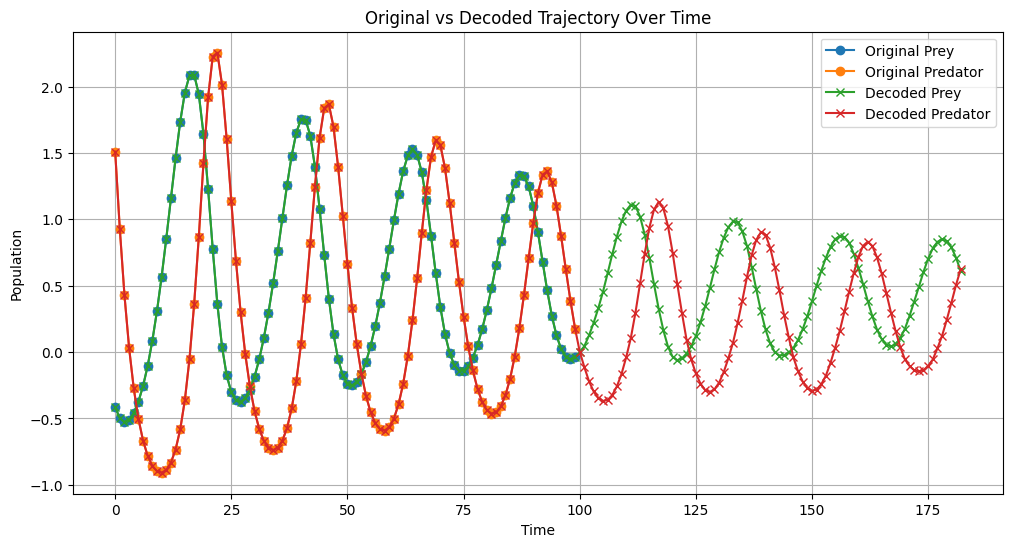

In [20]:
# plot
decoded_trajectory = decode([predicted_text])[0]  # Decode the generated text
original_trajectory = decode([original_text])[0]  # Decode the original text

plt.figure(figsize=(12, 6))
plt.plot(original_trajectory[:, 0], label="Original Prey", marker='o')
plt.plot(original_trajectory[:, 1], label="Original Predator", marker='o')
plt.plot(decoded_trajectory[:, 0], label="Decoded Prey", marker='x')
plt.plot(decoded_trajectory[:, 1], label="Decoded Predator", marker='x')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Original vs Decoded Trajectory Over Time")
plt.legend()
plt.grid()
plt.show()

## Baseline

In [21]:
# Load the base model
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

In [ ]:
# run inference on the first example
example = tokenized_test_dataset[0]
print(f"Number of tokens of the example sequence: {len(example['input_ids'])}")
input_ids = torch.tensor(example["input_ids"])[None, :].to(device)
attention_mask = torch.tensor(example["attention_mask"])[None, :].to(device)

In [22]:
generated_ids = base_model.generate(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    max_new_tokens=1000)

In [23]:
predicted_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
original_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

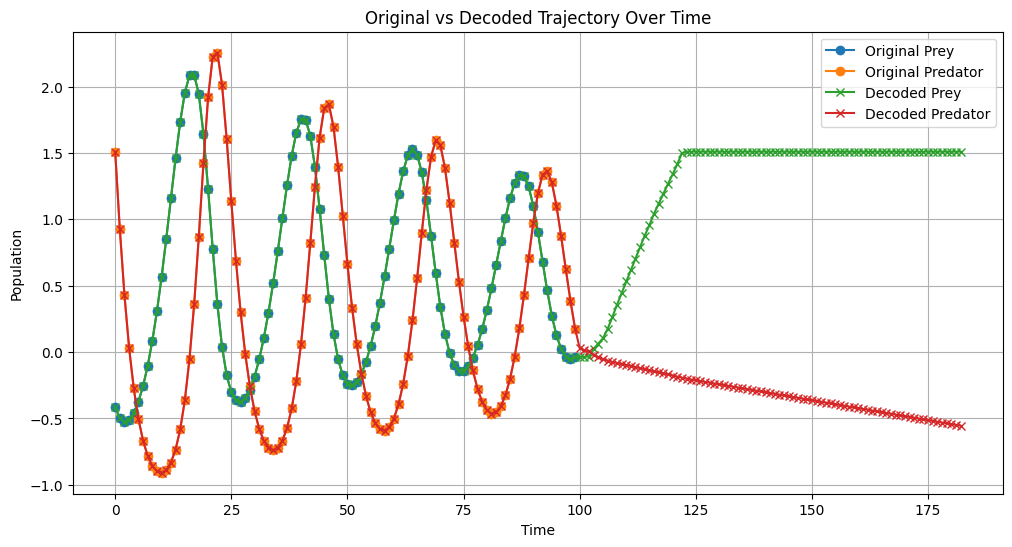

In [24]:
# plot
decoded_trajectory = decode([predicted_text])[0]  # Decode the generated text
original_trajectory = decode([original_text])[0]  # Decode the original text

plt.figure(figsize=(12, 6))
plt.plot(original_trajectory[:, 0], label="Original Prey", marker='o')
plt.plot(original_trajectory[:, 1], label="Original Predator", marker='o')
plt.plot(decoded_trajectory[:, 0], label="Decoded Prey", marker='x')
plt.plot(decoded_trajectory[:, 1], label="Decoded Predator", marker='x')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Original vs Decoded Trajectory Over Time")
plt.legend()
plt.grid()
plt.show()

#Visualize Training Loss

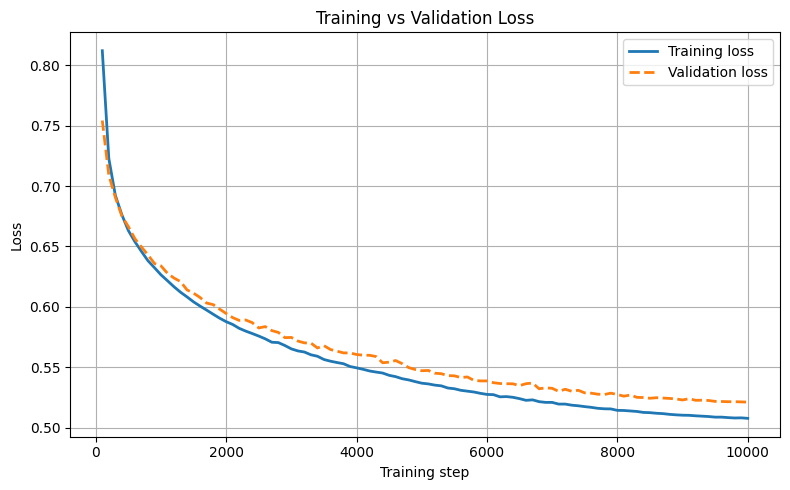

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example: manually input or load from file
steps = np.arange(100, 10001, 100)  # steps from your log (every 100)
train_loss = [
    0.812000, 0.722800, 0.692300, 0.676200, 0.663100, 0.653900, 0.645900, 0.638200, 0.632400, 0.626500,
    0.621600, 0.616600, 0.612100, 0.608200, 0.604100, 0.600600, 0.597300, 0.593900, 0.590600, 0.587700,
    0.585400, 0.582200, 0.579900, 0.577900, 0.575800, 0.573500, 0.570700, 0.570400, 0.568000, 0.565200,
    0.563500, 0.562600, 0.560300, 0.559100, 0.556400, 0.555000, 0.553900, 0.552900, 0.550600, 0.549500,
    0.548300, 0.546900, 0.546000, 0.545200, 0.543300, 0.542200, 0.540500, 0.539500, 0.538100, 0.536800,
    0.536200, 0.535200, 0.534600, 0.532800, 0.532200, 0.530900, 0.530200, 0.529500, 0.528400, 0.527500,
    0.527300, 0.525500, 0.525700, 0.525100, 0.524000, 0.522600, 0.523000, 0.521500, 0.520900, 0.520900,
    0.519500, 0.519500, 0.518600, 0.518100, 0.517400, 0.516800, 0.516000, 0.515600, 0.515500, 0.514300,
    0.514200, 0.513800, 0.513400, 0.512600, 0.512400, 0.511900, 0.511600, 0.511000, 0.510600, 0.510300,
    0.510200, 0.509800, 0.509500, 0.509200, 0.508700, 0.508700, 0.508300, 0.508000, 0.508100, 0.507700
]

val_loss = [
    0.754219, 0.708997, 0.690699, 0.675192, 0.666365, 0.656415, 0.649570, 0.642996, 0.635860, 0.633903,
    0.627733, 0.623819, 0.620900, 0.614010, 0.611286, 0.607720, 0.603131, 0.601842, 0.598091, 0.594475,
    0.591083, 0.588752, 0.589101, 0.586896, 0.582521, 0.583631, 0.580342, 0.578821, 0.574489, 0.574675,
    0.571670, 0.570162, 0.570002, 0.565947, 0.567839, 0.564669, 0.563316, 0.561871, 0.561818, 0.560539,
    0.559948, 0.559900, 0.558832, 0.553712, 0.554197, 0.555545, 0.552964, 0.549703, 0.548107, 0.547116,
    0.547336, 0.545068, 0.544648, 0.543060, 0.542880, 0.541494, 0.541944, 0.539125, 0.538676, 0.538671,
    0.537201, 0.536538, 0.536373, 0.536265, 0.534790, 0.536390, 0.536899, 0.532189, 0.532922, 0.532564,
    0.530035, 0.531775, 0.530125, 0.530928, 0.528781, 0.528524, 0.527690, 0.527435, 0.528535, 0.527423,
    0.526046, 0.526998, 0.525083, 0.524907, 0.524329, 0.524769, 0.524492, 0.524190, 0.523758, 0.522907,
    0.523941, 0.522639, 0.522705, 0.522470, 0.521730, 0.521631, 0.521468, 0.521463, 0.521318, 0.521122
]

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Training loss", linewidth=2)
plt.plot(steps, val_loss, label="Validation loss", linewidth=2, linestyle="--")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
